# Architektur Neuronales Netz

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            #nn.LayerNorm(hidden1_size),
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            #nn.LayerNorm(hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            #nn.LayerNorm(hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 1)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=200, bias=True)
    (2): Tanh()
    (3): Linear(in_features=200, out_features=200, bias=True)
    (4): Tanh()
    (5): Linear(in_features=200, out_features=200, bias=True)
    (6): Tanh()
    (7): Linear(in_features=200, out_features=1, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 32 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs xi
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
xi = torch.tensor(res['xi'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000

# T = torch.tensor(res['T']).float()
# p = torch.tensor(res['p']).float()
# x_0 = torch.tensor(res['x_0']).float()
# xi = torch.tensor(res['xi']).float()

# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = xi.reshape((-1,1))
#print(x_input.size())
# print(xi.size())

# Tensoren zu einem großen Set gruppieren
dataset = TensorDataset(x_input, y_output)

# for x,y in dataset:
#     print(x)
#     print(y)
    
# Split in Trainings und Test Set
train_dataset, test_dataset = random_split(dataset, 
                                           [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
                                           generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 1)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)

#### Funktion zur Bestimmung der Genauigkeit

In [7]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred, y)

            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if pred[i] - y[i] <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f} \n")

    net.train()
    
    return acc, loss, MRE

#### Training

In [8]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients

#         # Record the correct predictions for training data
#         _, predictions = torch.max(pred.data, 1)
#         train_correct += (predictions == y.data).sum()                
#         train_total += predictions.size(0)    

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping
    #train_loss.append(loss.item())
    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)

#     loss = criterion(outputs, Variable(test_classes))
#     test_loss.append(loss.data[0])

Epoch 1/200, Iteration 1/25, Loss: 0.1678
Epoch 1/200, Iteration 2/25, Loss: 0.1627
Epoch 1/200, Iteration 3/25, Loss: 0.1373
Epoch 1/200, Iteration 4/25, Loss: 0.0997
Epoch 1/200, Iteration 5/25, Loss: 0.0769
Epoch 1/200, Iteration 6/25, Loss: 0.0667
Epoch 1/200, Iteration 7/25, Loss: 0.0619
Epoch 1/200, Iteration 8/25, Loss: 0.0296
Epoch 1/200, Iteration 9/25, Loss: 0.0293
Epoch 1/200, Iteration 10/25, Loss: 0.0265
Epoch 1/200, Iteration 11/25, Loss: 0.0316
Epoch 1/200, Iteration 12/25, Loss: 0.0454
Epoch 1/200, Iteration 13/25, Loss: 0.0387
Epoch 1/200, Iteration 14/25, Loss: 0.0474
Epoch 1/200, Iteration 15/25, Loss: 0.0390
Epoch 1/200, Iteration 16/25, Loss: 0.0459
Epoch 1/200, Iteration 17/25, Loss: 0.0446
Epoch 1/200, Iteration 18/25, Loss: 0.0382
Epoch 1/200, Iteration 19/25, Loss: 0.0321
Epoch 1/200, Iteration 20/25, Loss: 0.0338
Epoch 1/200, Iteration 21/25, Loss: 0.0176
Epoch 1/200, Iteration 22/25, Loss: 0.0181
Epoch 1/200, Iteration 23/25, Loss: 0.0260
Epoch 1/200, Iterati

Test Error: 
 Accuracy: 86.0%, Avg loss: 0.017592, MRE: 3.965109 

Epoch 8/200, Iteration 1/25, Loss: 0.0342
Epoch 8/200, Iteration 2/25, Loss: 0.0164
Epoch 8/200, Iteration 3/25, Loss: 0.0186
Epoch 8/200, Iteration 4/25, Loss: 0.0236
Epoch 8/200, Iteration 5/25, Loss: 0.0172
Epoch 8/200, Iteration 6/25, Loss: 0.0599
Epoch 8/200, Iteration 7/25, Loss: 0.0240
Epoch 8/200, Iteration 8/25, Loss: 0.0361
Epoch 8/200, Iteration 9/25, Loss: 0.0189
Epoch 8/200, Iteration 10/25, Loss: 0.0231
Epoch 8/200, Iteration 11/25, Loss: 0.0178
Epoch 8/200, Iteration 12/25, Loss: 0.0286
Epoch 8/200, Iteration 13/25, Loss: 0.0255
Epoch 8/200, Iteration 14/25, Loss: 0.0305
Epoch 8/200, Iteration 15/25, Loss: 0.0165
Epoch 8/200, Iteration 16/25, Loss: 0.0317
Epoch 8/200, Iteration 17/25, Loss: 0.0197
Epoch 8/200, Iteration 18/25, Loss: 0.0337
Epoch 8/200, Iteration 19/25, Loss: 0.0277
Epoch 8/200, Iteration 20/25, Loss: 0.0244
Epoch 8/200, Iteration 21/25, Loss: 0.0188
Epoch 8/200, Iteration 22/25, Loss: 0.0

Epoch 15/200, Iteration 12/25, Loss: 0.0188
Epoch 15/200, Iteration 13/25, Loss: 0.0177
Epoch 15/200, Iteration 14/25, Loss: 0.0254
Epoch 15/200, Iteration 15/25, Loss: 0.0194
Epoch 15/200, Iteration 16/25, Loss: 0.0126
Epoch 15/200, Iteration 17/25, Loss: 0.0148
Epoch 15/200, Iteration 18/25, Loss: 0.0106
Epoch 15/200, Iteration 19/25, Loss: 0.0100
Epoch 15/200, Iteration 20/25, Loss: 0.0196
Epoch 15/200, Iteration 21/25, Loss: 0.0176
Epoch 15/200, Iteration 22/25, Loss: 0.0155
Epoch 15/200, Iteration 23/25, Loss: 0.0194
Epoch 15/200, Iteration 24/25, Loss: 0.0239
Epoch 15/200, Iteration 25/25, Loss: 0.0252
Train Error: 
 Accuracy: 84.88%, Avg loss: 0.014346, MRE: 1.184985 

Test Error: 
 Accuracy: 82.5%, Avg loss: 0.014919, MRE: 1.746824 

Epoch 16/200, Iteration 1/25, Loss: 0.0104
Epoch 16/200, Iteration 2/25, Loss: 0.0166
Epoch 16/200, Iteration 3/25, Loss: 0.0121
Epoch 16/200, Iteration 4/25, Loss: 0.0106
Epoch 16/200, Iteration 5/25, Loss: 0.0195
Epoch 16/200, Iteration 6/25, Los

Epoch 22/200, Iteration 18/25, Loss: 0.0148
Epoch 22/200, Iteration 19/25, Loss: 0.0243
Epoch 22/200, Iteration 20/25, Loss: 0.0248
Epoch 22/200, Iteration 21/25, Loss: 0.0166
Epoch 22/200, Iteration 22/25, Loss: 0.0282
Epoch 22/200, Iteration 23/25, Loss: 0.0113
Epoch 22/200, Iteration 24/25, Loss: 0.0578
Epoch 22/200, Iteration 25/25, Loss: 0.0297
Train Error: 
 Accuracy: 83.75%, Avg loss: 0.020263, MRE: 1.424889 

Test Error: 
 Accuracy: 82.5%, Avg loss: 0.019606, MRE: 4.662794 

Epoch 23/200, Iteration 1/25, Loss: 0.0377
Epoch 23/200, Iteration 2/25, Loss: 0.0193
Epoch 23/200, Iteration 3/25, Loss: 0.0292
Epoch 23/200, Iteration 4/25, Loss: 0.0187
Epoch 23/200, Iteration 5/25, Loss: 0.0159
Epoch 23/200, Iteration 6/25, Loss: 0.0084
Epoch 23/200, Iteration 7/25, Loss: 0.0196
Epoch 23/200, Iteration 8/25, Loss: 0.0056
Epoch 23/200, Iteration 9/25, Loss: 0.0140
Epoch 23/200, Iteration 10/25, Loss: 0.0269
Epoch 23/200, Iteration 11/25, Loss: 0.0330
Epoch 23/200, Iteration 12/25, Loss: 

Train Error: 
 Accuracy: 77.75%, Avg loss: 0.008554, MRE: 0.476667 

Test Error: 
 Accuracy: 79.0%, Avg loss: 0.008801, MRE: 2.279752 

Epoch 30/200, Iteration 1/25, Loss: 0.0116
Epoch 30/200, Iteration 2/25, Loss: 0.0098
Epoch 30/200, Iteration 3/25, Loss: 0.0180
Epoch 30/200, Iteration 4/25, Loss: 0.0271
Epoch 30/200, Iteration 5/25, Loss: 0.0598
Epoch 30/200, Iteration 6/25, Loss: 0.0267
Epoch 30/200, Iteration 7/25, Loss: 0.0160
Epoch 30/200, Iteration 8/25, Loss: 0.0184
Epoch 30/200, Iteration 9/25, Loss: 0.0133
Epoch 30/200, Iteration 10/25, Loss: 0.0285
Epoch 30/200, Iteration 11/25, Loss: 0.0229
Epoch 30/200, Iteration 12/25, Loss: 0.0310
Epoch 30/200, Iteration 13/25, Loss: 0.0425
Epoch 30/200, Iteration 14/25, Loss: 0.0191
Epoch 30/200, Iteration 15/25, Loss: 0.0186
Epoch 30/200, Iteration 16/25, Loss: 0.0371
Epoch 30/200, Iteration 17/25, Loss: 0.0144
Epoch 30/200, Iteration 18/25, Loss: 0.0262
Epoch 30/200, Iteration 19/25, Loss: 0.0208
Epoch 30/200, Iteration 20/25, Loss: 

Epoch 37/200, Iteration 2/25, Loss: 0.0054
Epoch 37/200, Iteration 3/25, Loss: 0.0154
Epoch 37/200, Iteration 4/25, Loss: 0.0166
Epoch 37/200, Iteration 5/25, Loss: 0.0237
Epoch 37/200, Iteration 6/25, Loss: 0.0559
Epoch 37/200, Iteration 7/25, Loss: 0.0170
Epoch 37/200, Iteration 8/25, Loss: 0.0219
Epoch 37/200, Iteration 9/25, Loss: 0.0283
Epoch 37/200, Iteration 10/25, Loss: 0.0352
Epoch 37/200, Iteration 11/25, Loss: 0.0180
Epoch 37/200, Iteration 12/25, Loss: 0.0264
Epoch 37/200, Iteration 13/25, Loss: 0.0151
Epoch 37/200, Iteration 14/25, Loss: 0.0183
Epoch 37/200, Iteration 15/25, Loss: 0.0093
Epoch 37/200, Iteration 16/25, Loss: 0.0178
Epoch 37/200, Iteration 17/25, Loss: 0.0086
Epoch 37/200, Iteration 18/25, Loss: 0.0196
Epoch 37/200, Iteration 19/25, Loss: 0.0366
Epoch 37/200, Iteration 20/25, Loss: 0.0432
Epoch 37/200, Iteration 21/25, Loss: 0.0121
Epoch 37/200, Iteration 22/25, Loss: 0.0106
Epoch 37/200, Iteration 23/25, Loss: 0.0376
Epoch 37/200, Iteration 24/25, Loss: 0.0

Epoch 43/200, Iteration 25/25, Loss: 0.0335
Train Error: 
 Accuracy: 97.0%, Avg loss: 0.016739, MRE: 0.971399 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.018172, MRE: 4.113203 

Epoch 44/200, Iteration 1/25, Loss: 0.0122
Epoch 44/200, Iteration 2/25, Loss: 0.0165
Epoch 44/200, Iteration 3/25, Loss: 0.0247
Epoch 44/200, Iteration 4/25, Loss: 0.0110
Epoch 44/200, Iteration 5/25, Loss: 0.0201
Epoch 44/200, Iteration 6/25, Loss: 0.0128
Epoch 44/200, Iteration 7/25, Loss: 0.0130
Epoch 44/200, Iteration 8/25, Loss: 0.0194
Epoch 44/200, Iteration 9/25, Loss: 0.0217
Epoch 44/200, Iteration 10/25, Loss: 0.0095
Epoch 44/200, Iteration 11/25, Loss: 0.0216
Epoch 44/200, Iteration 12/25, Loss: 0.0172
Epoch 44/200, Iteration 13/25, Loss: 0.0248
Epoch 44/200, Iteration 14/25, Loss: 0.0091
Epoch 44/200, Iteration 15/25, Loss: 0.0085
Epoch 44/200, Iteration 16/25, Loss: 0.0269
Epoch 44/200, Iteration 17/25, Loss: 0.0508
Epoch 44/200, Iteration 18/25, Loss: 0.0471
Epoch 44/200, Iteration 19/25, Loss: 0

Train Error: 
 Accuracy: 74.38%, Avg loss: 0.009356, MRE: 0.552880 

Test Error: 
 Accuracy: 72.0%, Avg loss: 0.009753, MRE: 2.136490 

Epoch 51/200, Iteration 1/25, Loss: 0.0117
Epoch 51/200, Iteration 2/25, Loss: 0.0093
Epoch 51/200, Iteration 3/25, Loss: 0.0124
Epoch 51/200, Iteration 4/25, Loss: 0.0159
Epoch 51/200, Iteration 5/25, Loss: 0.0149
Epoch 51/200, Iteration 6/25, Loss: 0.0101
Epoch 51/200, Iteration 7/25, Loss: 0.0219
Epoch 51/200, Iteration 8/25, Loss: 0.0098
Epoch 51/200, Iteration 9/25, Loss: 0.0139
Epoch 51/200, Iteration 10/25, Loss: 0.0107
Epoch 51/200, Iteration 11/25, Loss: 0.0149
Epoch 51/200, Iteration 12/25, Loss: 0.0120
Epoch 51/200, Iteration 13/25, Loss: 0.0400
Epoch 51/200, Iteration 14/25, Loss: 0.0205
Epoch 51/200, Iteration 15/25, Loss: 0.0110
Epoch 51/200, Iteration 16/25, Loss: 0.0164
Epoch 51/200, Iteration 17/25, Loss: 0.0133
Epoch 51/200, Iteration 18/25, Loss: 0.0312
Epoch 51/200, Iteration 19/25, Loss: 0.0201
Epoch 51/200, Iteration 20/25, Loss: 

Epoch 58/200, Iteration 15/25, Loss: 0.0223
Epoch 58/200, Iteration 16/25, Loss: 0.0398
Epoch 58/200, Iteration 17/25, Loss: 0.0093
Epoch 58/200, Iteration 18/25, Loss: 0.0239
Epoch 58/200, Iteration 19/25, Loss: 0.0140
Epoch 58/200, Iteration 20/25, Loss: 0.0404
Epoch 58/200, Iteration 21/25, Loss: 0.0166
Epoch 58/200, Iteration 22/25, Loss: 0.0100
Epoch 58/200, Iteration 23/25, Loss: 0.0324
Epoch 58/200, Iteration 24/25, Loss: 0.0326
Epoch 58/200, Iteration 25/25, Loss: 0.0120
Train Error: 
 Accuracy: 97.25%, Avg loss: 0.012610, MRE: 0.558493 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.014152, MRE: 2.901759 

Epoch 59/200, Iteration 1/25, Loss: 0.0092
Epoch 59/200, Iteration 2/25, Loss: 0.0226
Epoch 59/200, Iteration 3/25, Loss: 0.0205
Epoch 59/200, Iteration 4/25, Loss: 0.0106
Epoch 59/200, Iteration 5/25, Loss: 0.0182
Epoch 59/200, Iteration 6/25, Loss: 0.0113
Epoch 59/200, Iteration 7/25, Loss: 0.0270
Epoch 59/200, Iteration 8/25, Loss: 0.0186
Epoch 59/200, Iteration 9/25, Loss: 

Epoch 65/200, Iteration 14/25, Loss: 0.0132
Epoch 65/200, Iteration 15/25, Loss: 0.0134
Epoch 65/200, Iteration 16/25, Loss: 0.0164
Epoch 65/200, Iteration 17/25, Loss: 0.0297
Epoch 65/200, Iteration 18/25, Loss: 0.0266
Epoch 65/200, Iteration 19/25, Loss: 0.0141
Epoch 65/200, Iteration 20/25, Loss: 0.0115
Epoch 65/200, Iteration 21/25, Loss: 0.0185
Epoch 65/200, Iteration 22/25, Loss: 0.0090
Epoch 65/200, Iteration 23/25, Loss: 0.0106
Epoch 65/200, Iteration 24/25, Loss: 0.0336
Epoch 65/200, Iteration 25/25, Loss: 0.0187
Train Error: 
 Accuracy: 53.5%, Avg loss: 0.014932, MRE: 0.659054 

Test Error: 
 Accuracy: 51.0%, Avg loss: 0.015515, MRE: 1.859964 

Epoch 66/200, Iteration 1/25, Loss: 0.0392
Epoch 66/200, Iteration 2/25, Loss: 0.0258
Epoch 66/200, Iteration 3/25, Loss: 0.0102
Epoch 66/200, Iteration 4/25, Loss: 0.0219
Epoch 66/200, Iteration 5/25, Loss: 0.0180
Epoch 66/200, Iteration 6/25, Loss: 0.0203
Epoch 66/200, Iteration 7/25, Loss: 0.0198
Epoch 66/200, Iteration 8/25, Loss: 

Epoch 72/200, Iteration 23/25, Loss: 0.0118
Epoch 72/200, Iteration 24/25, Loss: 0.0114
Epoch 72/200, Iteration 25/25, Loss: 0.0134
Train Error: 
 Accuracy: 87.12%, Avg loss: 0.009124, MRE: 0.500433 

Test Error: 
 Accuracy: 87.5%, Avg loss: 0.009606, MRE: 2.520974 

Epoch 73/200, Iteration 1/25, Loss: 0.0181
Epoch 73/200, Iteration 2/25, Loss: 0.0209
Epoch 73/200, Iteration 3/25, Loss: 0.0110
Epoch 73/200, Iteration 4/25, Loss: 0.0100
Epoch 73/200, Iteration 5/25, Loss: 0.0092
Epoch 73/200, Iteration 6/25, Loss: 0.0273
Epoch 73/200, Iteration 7/25, Loss: 0.0088
Epoch 73/200, Iteration 8/25, Loss: 0.0077
Epoch 73/200, Iteration 9/25, Loss: 0.0096
Epoch 73/200, Iteration 10/25, Loss: 0.0096
Epoch 73/200, Iteration 11/25, Loss: 0.0111
Epoch 73/200, Iteration 12/25, Loss: 0.0361
Epoch 73/200, Iteration 13/25, Loss: 0.0172
Epoch 73/200, Iteration 14/25, Loss: 0.0185
Epoch 73/200, Iteration 15/25, Loss: 0.0168
Epoch 73/200, Iteration 16/25, Loss: 0.0101
Epoch 73/200, Iteration 17/25, Loss: 

Epoch 80/200, Iteration 7/25, Loss: 0.0164
Epoch 80/200, Iteration 8/25, Loss: 0.0179
Epoch 80/200, Iteration 9/25, Loss: 0.0309
Epoch 80/200, Iteration 10/25, Loss: 0.0071
Epoch 80/200, Iteration 11/25, Loss: 0.0083
Epoch 80/200, Iteration 12/25, Loss: 0.0084
Epoch 80/200, Iteration 13/25, Loss: 0.0110
Epoch 80/200, Iteration 14/25, Loss: 0.0177
Epoch 80/200, Iteration 15/25, Loss: 0.0130
Epoch 80/200, Iteration 16/25, Loss: 0.0279
Epoch 80/200, Iteration 17/25, Loss: 0.0136
Epoch 80/200, Iteration 18/25, Loss: 0.0299
Epoch 80/200, Iteration 19/25, Loss: 0.0168
Epoch 80/200, Iteration 20/25, Loss: 0.0099
Epoch 80/200, Iteration 21/25, Loss: 0.0187
Epoch 80/200, Iteration 22/25, Loss: 0.0217
Epoch 80/200, Iteration 23/25, Loss: 0.0253
Epoch 80/200, Iteration 24/25, Loss: 0.0421
Epoch 80/200, Iteration 25/25, Loss: 0.0089
Train Error: 
 Accuracy: 89.0%, Avg loss: 0.007287, MRE: 0.479045 

Test Error: 
 Accuracy: 89.5%, Avg loss: 0.007302, MRE: 1.719630 

Epoch 81/200, Iteration 1/25, Lo

Epoch 87/200, Iteration 14/25, Loss: 0.0150
Epoch 87/200, Iteration 15/25, Loss: 0.0261
Epoch 87/200, Iteration 16/25, Loss: 0.0178
Epoch 87/200, Iteration 17/25, Loss: 0.0182
Epoch 87/200, Iteration 18/25, Loss: 0.0143
Epoch 87/200, Iteration 19/25, Loss: 0.0153
Epoch 87/200, Iteration 20/25, Loss: 0.0109
Epoch 87/200, Iteration 21/25, Loss: 0.0141
Epoch 87/200, Iteration 22/25, Loss: 0.0071
Epoch 87/200, Iteration 23/25, Loss: 0.0159
Epoch 87/200, Iteration 24/25, Loss: 0.0077
Epoch 87/200, Iteration 25/25, Loss: 0.0120
Train Error: 
 Accuracy: 82.12%, Avg loss: 0.011294, MRE: 0.699517 

Test Error: 
 Accuracy: 80.0%, Avg loss: 0.011013, MRE: 2.856201 

Epoch 88/200, Iteration 1/25, Loss: 0.0332
Epoch 88/200, Iteration 2/25, Loss: 0.0213
Epoch 88/200, Iteration 3/25, Loss: 0.0124
Epoch 88/200, Iteration 4/25, Loss: 0.0331
Epoch 88/200, Iteration 5/25, Loss: 0.0199
Epoch 88/200, Iteration 6/25, Loss: 0.0209
Epoch 88/200, Iteration 7/25, Loss: 0.0104
Epoch 88/200, Iteration 8/25, Loss:

Epoch 94/200, Iteration 13/25, Loss: 0.0119
Epoch 94/200, Iteration 14/25, Loss: 0.0191
Epoch 94/200, Iteration 15/25, Loss: 0.0177
Epoch 94/200, Iteration 16/25, Loss: 0.0077
Epoch 94/200, Iteration 17/25, Loss: 0.0151
Epoch 94/200, Iteration 18/25, Loss: 0.0163
Epoch 94/200, Iteration 19/25, Loss: 0.0143
Epoch 94/200, Iteration 20/25, Loss: 0.0220
Epoch 94/200, Iteration 21/25, Loss: 0.0388
Epoch 94/200, Iteration 22/25, Loss: 0.0150
Epoch 94/200, Iteration 23/25, Loss: 0.0277
Epoch 94/200, Iteration 24/25, Loss: 0.0211
Epoch 94/200, Iteration 25/25, Loss: 0.0158
Train Error: 
 Accuracy: 83.88%, Avg loss: 0.008015, MRE: 0.519174 

Test Error: 
 Accuracy: 85.0%, Avg loss: 0.007518, MRE: 1.906890 

Epoch 95/200, Iteration 1/25, Loss: 0.0157
Epoch 95/200, Iteration 2/25, Loss: 0.0125
Epoch 95/200, Iteration 3/25, Loss: 0.0166
Epoch 95/200, Iteration 4/25, Loss: 0.0121
Epoch 95/200, Iteration 5/25, Loss: 0.0105
Epoch 95/200, Iteration 6/25, Loss: 0.0253
Epoch 95/200, Iteration 7/25, Loss

Epoch 102/200, Iteration 7/25, Loss: 0.0111
Epoch 102/200, Iteration 8/25, Loss: 0.0110
Epoch 102/200, Iteration 9/25, Loss: 0.0483
Epoch 102/200, Iteration 10/25, Loss: 0.0220
Epoch 102/200, Iteration 11/25, Loss: 0.0166
Epoch 102/200, Iteration 12/25, Loss: 0.0275
Epoch 102/200, Iteration 13/25, Loss: 0.0227
Epoch 102/200, Iteration 14/25, Loss: 0.0134
Epoch 102/200, Iteration 15/25, Loss: 0.0138
Epoch 102/200, Iteration 16/25, Loss: 0.0084
Epoch 102/200, Iteration 17/25, Loss: 0.0176
Epoch 102/200, Iteration 18/25, Loss: 0.0077
Epoch 102/200, Iteration 19/25, Loss: 0.0208
Epoch 102/200, Iteration 20/25, Loss: 0.0103
Epoch 102/200, Iteration 21/25, Loss: 0.0317
Epoch 102/200, Iteration 22/25, Loss: 0.0044
Epoch 102/200, Iteration 23/25, Loss: 0.0081
Epoch 102/200, Iteration 24/25, Loss: 0.0127
Epoch 102/200, Iteration 25/25, Loss: 0.0134
Train Error: 
 Accuracy: 73.38%, Avg loss: 0.009234, MRE: 0.648186 

Test Error: 
 Accuracy: 70.5%, Avg loss: 0.008802, MRE: 0.982853 

Epoch 103/20

Epoch 109/200, Iteration 6/25, Loss: 0.0114
Epoch 109/200, Iteration 7/25, Loss: 0.0239
Epoch 109/200, Iteration 8/25, Loss: 0.0137
Epoch 109/200, Iteration 9/25, Loss: 0.0105
Epoch 109/200, Iteration 10/25, Loss: 0.0238
Epoch 109/200, Iteration 11/25, Loss: 0.0357
Epoch 109/200, Iteration 12/25, Loss: 0.0164
Epoch 109/200, Iteration 13/25, Loss: 0.0120
Epoch 109/200, Iteration 14/25, Loss: 0.0359
Epoch 109/200, Iteration 15/25, Loss: 0.0377
Epoch 109/200, Iteration 16/25, Loss: 0.0099
Epoch 109/200, Iteration 17/25, Loss: 0.0099
Epoch 109/200, Iteration 18/25, Loss: 0.0086
Epoch 109/200, Iteration 19/25, Loss: 0.0146
Epoch 109/200, Iteration 20/25, Loss: 0.0158
Epoch 109/200, Iteration 21/25, Loss: 0.0216
Epoch 109/200, Iteration 22/25, Loss: 0.0087
Epoch 109/200, Iteration 23/25, Loss: 0.0207
Epoch 109/200, Iteration 24/25, Loss: 0.0184
Epoch 109/200, Iteration 25/25, Loss: 0.0172
Train Error: 
 Accuracy: 94.75%, Avg loss: 0.011754, MRE: 0.816018 

Test Error: 
 Accuracy: 92.0%, Avg 

Epoch 116/200, Iteration 19/25, Loss: 0.0185
Epoch 116/200, Iteration 20/25, Loss: 0.0242
Epoch 116/200, Iteration 21/25, Loss: 0.0178
Epoch 116/200, Iteration 22/25, Loss: 0.0248
Epoch 116/200, Iteration 23/25, Loss: 0.0235
Epoch 116/200, Iteration 24/25, Loss: 0.0222
Epoch 116/200, Iteration 25/25, Loss: 0.0576
Train Error: 
 Accuracy: 56.75%, Avg loss: 0.011697, MRE: 0.772568 

Test Error: 
 Accuracy: 58.5%, Avg loss: 0.011332, MRE: 1.108822 

Epoch 117/200, Iteration 1/25, Loss: 0.0162
Epoch 117/200, Iteration 2/25, Loss: 0.0164
Epoch 117/200, Iteration 3/25, Loss: 0.0387
Epoch 117/200, Iteration 4/25, Loss: 0.0199
Epoch 117/200, Iteration 5/25, Loss: 0.0199
Epoch 117/200, Iteration 6/25, Loss: 0.0081
Epoch 117/200, Iteration 7/25, Loss: 0.0254
Epoch 117/200, Iteration 8/25, Loss: 0.0138
Epoch 117/200, Iteration 9/25, Loss: 0.0197
Epoch 117/200, Iteration 10/25, Loss: 0.0140
Epoch 117/200, Iteration 11/25, Loss: 0.0253
Epoch 117/200, Iteration 12/25, Loss: 0.0281
Epoch 117/200, Ite

Epoch 124/200, Iteration 9/25, Loss: 0.0123
Epoch 124/200, Iteration 10/25, Loss: 0.0121
Epoch 124/200, Iteration 11/25, Loss: 0.0103
Epoch 124/200, Iteration 12/25, Loss: 0.0214
Epoch 124/200, Iteration 13/25, Loss: 0.0154
Epoch 124/200, Iteration 14/25, Loss: 0.0075
Epoch 124/200, Iteration 15/25, Loss: 0.0161
Epoch 124/200, Iteration 16/25, Loss: 0.0240
Epoch 124/200, Iteration 17/25, Loss: 0.0063
Epoch 124/200, Iteration 18/25, Loss: 0.0095
Epoch 124/200, Iteration 19/25, Loss: 0.0368
Epoch 124/200, Iteration 20/25, Loss: 0.0160
Epoch 124/200, Iteration 21/25, Loss: 0.0129
Epoch 124/200, Iteration 22/25, Loss: 0.0077
Epoch 124/200, Iteration 23/25, Loss: 0.0171
Epoch 124/200, Iteration 24/25, Loss: 0.0075
Epoch 124/200, Iteration 25/25, Loss: 0.0107
Train Error: 
 Accuracy: 92.62%, Avg loss: 0.005354, MRE: 0.402691 

Test Error: 
 Accuracy: 91.5%, Avg loss: 0.005637, MRE: 0.996650 

Epoch 125/200, Iteration 1/25, Loss: 0.0095
Epoch 125/200, Iteration 2/25, Loss: 0.0245
Epoch 125/20

Train Error: 
 Accuracy: 90.12%, Avg loss: 0.007018, MRE: 0.348848 

Test Error: 
 Accuracy: 89.5%, Avg loss: 0.007676, MRE: 0.950284 

Epoch 131/200, Iteration 1/25, Loss: 0.0090
Epoch 131/200, Iteration 2/25, Loss: 0.0193
Epoch 131/200, Iteration 3/25, Loss: 0.0144
Epoch 131/200, Iteration 4/25, Loss: 0.0274
Epoch 131/200, Iteration 5/25, Loss: 0.0074
Epoch 131/200, Iteration 6/25, Loss: 0.0193
Epoch 131/200, Iteration 7/25, Loss: 0.0136
Epoch 131/200, Iteration 8/25, Loss: 0.0168
Epoch 131/200, Iteration 9/25, Loss: 0.0208
Epoch 131/200, Iteration 10/25, Loss: 0.0129
Epoch 131/200, Iteration 11/25, Loss: 0.0093
Epoch 131/200, Iteration 12/25, Loss: 0.0157
Epoch 131/200, Iteration 13/25, Loss: 0.0160
Epoch 131/200, Iteration 14/25, Loss: 0.0205
Epoch 131/200, Iteration 15/25, Loss: 0.0184
Epoch 131/200, Iteration 16/25, Loss: 0.0126
Epoch 131/200, Iteration 17/25, Loss: 0.0163
Epoch 131/200, Iteration 18/25, Loss: 0.0162
Epoch 131/200, Iteration 19/25, Loss: 0.0257
Epoch 131/200, Ite

Train Error: 
 Accuracy: 83.75%, Avg loss: 0.007325, MRE: 0.537851 

Test Error: 
 Accuracy: 82.5%, Avg loss: 0.007060, MRE: 1.756893 

Epoch 138/200, Iteration 1/25, Loss: 0.0100
Epoch 138/200, Iteration 2/25, Loss: 0.0097
Epoch 138/200, Iteration 3/25, Loss: 0.0124
Epoch 138/200, Iteration 4/25, Loss: 0.0080
Epoch 138/200, Iteration 5/25, Loss: 0.0319
Epoch 138/200, Iteration 6/25, Loss: 0.0127
Epoch 138/200, Iteration 7/25, Loss: 0.0113
Epoch 138/200, Iteration 8/25, Loss: 0.0270
Epoch 138/200, Iteration 9/25, Loss: 0.0567
Epoch 138/200, Iteration 10/25, Loss: 0.0255
Epoch 138/200, Iteration 11/25, Loss: 0.0138
Epoch 138/200, Iteration 12/25, Loss: 0.0168
Epoch 138/200, Iteration 13/25, Loss: 0.0145
Epoch 138/200, Iteration 14/25, Loss: 0.0243
Epoch 138/200, Iteration 15/25, Loss: 0.0100
Epoch 138/200, Iteration 16/25, Loss: 0.0098
Epoch 138/200, Iteration 17/25, Loss: 0.0194
Epoch 138/200, Iteration 18/25, Loss: 0.0122
Epoch 138/200, Iteration 19/25, Loss: 0.0201
Epoch 138/200, Ite

Epoch 144/200, Iteration 24/25, Loss: 0.0140
Epoch 144/200, Iteration 25/25, Loss: 0.0194
Train Error: 
 Accuracy: 86.62%, Avg loss: 0.006706, MRE: 0.329598 

Test Error: 
 Accuracy: 86.5%, Avg loss: 0.006800, MRE: 1.789930 

Epoch 145/200, Iteration 1/25, Loss: 0.0096
Epoch 145/200, Iteration 2/25, Loss: 0.0248
Epoch 145/200, Iteration 3/25, Loss: 0.0278
Epoch 145/200, Iteration 4/25, Loss: 0.0085
Epoch 145/200, Iteration 5/25, Loss: 0.0141
Epoch 145/200, Iteration 6/25, Loss: 0.0096
Epoch 145/200, Iteration 7/25, Loss: 0.0056
Epoch 145/200, Iteration 8/25, Loss: 0.0118
Epoch 145/200, Iteration 9/25, Loss: 0.0138
Epoch 145/200, Iteration 10/25, Loss: 0.0235
Epoch 145/200, Iteration 11/25, Loss: 0.0181
Epoch 145/200, Iteration 12/25, Loss: 0.0179
Epoch 145/200, Iteration 13/25, Loss: 0.0219
Epoch 145/200, Iteration 14/25, Loss: 0.0194
Epoch 145/200, Iteration 15/25, Loss: 0.0146
Epoch 145/200, Iteration 16/25, Loss: 0.0105
Epoch 145/200, Iteration 17/25, Loss: 0.0300
Epoch 145/200, Ite

Epoch 151/200, Iteration 12/25, Loss: 0.0064
Epoch 151/200, Iteration 13/25, Loss: 0.0191
Epoch 151/200, Iteration 14/25, Loss: 0.0266
Epoch 151/200, Iteration 15/25, Loss: 0.0170
Epoch 151/200, Iteration 16/25, Loss: 0.0117
Epoch 151/200, Iteration 17/25, Loss: 0.0262
Epoch 151/200, Iteration 18/25, Loss: 0.0127
Epoch 151/200, Iteration 19/25, Loss: 0.0133
Epoch 151/200, Iteration 20/25, Loss: 0.0191
Epoch 151/200, Iteration 21/25, Loss: 0.0265
Epoch 151/200, Iteration 22/25, Loss: 0.0182
Epoch 151/200, Iteration 23/25, Loss: 0.0149
Epoch 151/200, Iteration 24/25, Loss: 0.0211
Epoch 151/200, Iteration 25/25, Loss: 0.0141
Train Error: 
 Accuracy: 68.12%, Avg loss: 0.009196, MRE: 0.578680 

Test Error: 
 Accuracy: 66.0%, Avg loss: 0.009343, MRE: 1.298181 

Epoch 152/200, Iteration 1/25, Loss: 0.0396
Epoch 152/200, Iteration 2/25, Loss: 0.0057
Epoch 152/200, Iteration 3/25, Loss: 0.0126
Epoch 152/200, Iteration 4/25, Loss: 0.0242
Epoch 152/200, Iteration 5/25, Loss: 0.0137
Epoch 152/200,

Epoch 158/200, Iteration 7/25, Loss: 0.0131
Epoch 158/200, Iteration 8/25, Loss: 0.0058
Epoch 158/200, Iteration 9/25, Loss: 0.0276
Epoch 158/200, Iteration 10/25, Loss: 0.0105
Epoch 158/200, Iteration 11/25, Loss: 0.0223
Epoch 158/200, Iteration 12/25, Loss: 0.0229
Epoch 158/200, Iteration 13/25, Loss: 0.0137
Epoch 158/200, Iteration 14/25, Loss: 0.0160
Epoch 158/200, Iteration 15/25, Loss: 0.0157
Epoch 158/200, Iteration 16/25, Loss: 0.0102
Epoch 158/200, Iteration 17/25, Loss: 0.0120
Epoch 158/200, Iteration 18/25, Loss: 0.0136
Epoch 158/200, Iteration 19/25, Loss: 0.0285
Epoch 158/200, Iteration 20/25, Loss: 0.0070
Epoch 158/200, Iteration 21/25, Loss: 0.0075
Epoch 158/200, Iteration 22/25, Loss: 0.0090
Epoch 158/200, Iteration 23/25, Loss: 0.0096
Epoch 158/200, Iteration 24/25, Loss: 0.0171
Epoch 158/200, Iteration 25/25, Loss: 0.0136
Train Error: 
 Accuracy: 87.75%, Avg loss: 0.008958, MRE: 0.441509 

Test Error: 
 Accuracy: 86.5%, Avg loss: 0.009913, MRE: 0.662685 

Epoch 159/20

Train Error: 
 Accuracy: 97.75%, Avg loss: 0.005918, MRE: 0.362661 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.006602, MRE: 1.808818 

Epoch 165/200, Iteration 1/25, Loss: 0.0183
Epoch 165/200, Iteration 2/25, Loss: 0.0232
Epoch 165/200, Iteration 3/25, Loss: 0.0326
Epoch 165/200, Iteration 4/25, Loss: 0.0162
Epoch 165/200, Iteration 5/25, Loss: 0.0093
Epoch 165/200, Iteration 6/25, Loss: 0.0110
Epoch 165/200, Iteration 7/25, Loss: 0.0164
Epoch 165/200, Iteration 8/25, Loss: 0.0139
Epoch 165/200, Iteration 9/25, Loss: 0.0104
Epoch 165/200, Iteration 10/25, Loss: 0.0396
Epoch 165/200, Iteration 11/25, Loss: 0.0115
Epoch 165/200, Iteration 12/25, Loss: 0.0122
Epoch 165/200, Iteration 13/25, Loss: 0.0114
Epoch 165/200, Iteration 14/25, Loss: 0.0093
Epoch 165/200, Iteration 15/25, Loss: 0.0144
Epoch 165/200, Iteration 16/25, Loss: 0.0168
Epoch 165/200, Iteration 17/25, Loss: 0.0183
Epoch 165/200, Iteration 18/25, Loss: 0.0163
Epoch 165/200, Iteration 19/25, Loss: 0.0308
Epoch 165/200, Ite

Epoch 171/200, Iteration 23/25, Loss: 0.0451
Epoch 171/200, Iteration 24/25, Loss: 0.0156
Epoch 171/200, Iteration 25/25, Loss: 0.0153
Train Error: 
 Accuracy: 81.75%, Avg loss: 0.011141, MRE: 0.511375 

Test Error: 
 Accuracy: 83.5%, Avg loss: 0.011231, MRE: 1.909591 

Epoch 172/200, Iteration 1/25, Loss: 0.0175
Epoch 172/200, Iteration 2/25, Loss: 0.0168
Epoch 172/200, Iteration 3/25, Loss: 0.0114
Epoch 172/200, Iteration 4/25, Loss: 0.0218
Epoch 172/200, Iteration 5/25, Loss: 0.0203
Epoch 172/200, Iteration 6/25, Loss: 0.0115
Epoch 172/200, Iteration 7/25, Loss: 0.0127
Epoch 172/200, Iteration 8/25, Loss: 0.0099
Epoch 172/200, Iteration 9/25, Loss: 0.0207
Epoch 172/200, Iteration 10/25, Loss: 0.0192
Epoch 172/200, Iteration 11/25, Loss: 0.0100
Epoch 172/200, Iteration 12/25, Loss: 0.0247
Epoch 172/200, Iteration 13/25, Loss: 0.0400
Epoch 172/200, Iteration 14/25, Loss: 0.0124
Epoch 172/200, Iteration 15/25, Loss: 0.0330
Epoch 172/200, Iteration 16/25, Loss: 0.0079
Epoch 172/200, Ite

Epoch 179/200, Iteration 20/25, Loss: 0.0127
Epoch 179/200, Iteration 21/25, Loss: 0.0103
Epoch 179/200, Iteration 22/25, Loss: 0.0286
Epoch 179/200, Iteration 23/25, Loss: 0.0197
Epoch 179/200, Iteration 24/25, Loss: 0.0177
Epoch 179/200, Iteration 25/25, Loss: 0.0132
Train Error: 
 Accuracy: 86.38%, Avg loss: 0.007861, MRE: 0.417551 

Test Error: 
 Accuracy: 86.0%, Avg loss: 0.007936, MRE: 1.482441 

Epoch 180/200, Iteration 1/25, Loss: 0.0160
Epoch 180/200, Iteration 2/25, Loss: 0.0133
Epoch 180/200, Iteration 3/25, Loss: 0.0083
Epoch 180/200, Iteration 4/25, Loss: 0.0074
Epoch 180/200, Iteration 5/25, Loss: 0.0152
Epoch 180/200, Iteration 6/25, Loss: 0.0240
Epoch 180/200, Iteration 7/25, Loss: 0.0117
Epoch 180/200, Iteration 8/25, Loss: 0.0160
Epoch 180/200, Iteration 9/25, Loss: 0.0070
Epoch 180/200, Iteration 10/25, Loss: 0.0175
Epoch 180/200, Iteration 11/25, Loss: 0.0093
Epoch 180/200, Iteration 12/25, Loss: 0.0294
Epoch 180/200, Iteration 13/25, Loss: 0.0064
Epoch 180/200, Ite

Epoch 186/200, Iteration 24/25, Loss: 0.0186
Epoch 186/200, Iteration 25/25, Loss: 0.0287
Train Error: 
 Accuracy: 67.88%, Avg loss: 0.009395, MRE: 0.560609 

Test Error: 
 Accuracy: 67.5%, Avg loss: 0.009485, MRE: 1.306725 

Epoch 187/200, Iteration 1/25, Loss: 0.0115
Epoch 187/200, Iteration 2/25, Loss: 0.0108
Epoch 187/200, Iteration 3/25, Loss: 0.0206
Epoch 187/200, Iteration 4/25, Loss: 0.0417
Epoch 187/200, Iteration 5/25, Loss: 0.0078
Epoch 187/200, Iteration 6/25, Loss: 0.0322
Epoch 187/200, Iteration 7/25, Loss: 0.0177
Epoch 187/200, Iteration 8/25, Loss: 0.0128
Epoch 187/200, Iteration 9/25, Loss: 0.0186
Epoch 187/200, Iteration 10/25, Loss: 0.0165
Epoch 187/200, Iteration 11/25, Loss: 0.0112
Epoch 187/200, Iteration 12/25, Loss: 0.0106
Epoch 187/200, Iteration 13/25, Loss: 0.0243
Epoch 187/200, Iteration 14/25, Loss: 0.0122
Epoch 187/200, Iteration 15/25, Loss: 0.0178
Epoch 187/200, Iteration 16/25, Loss: 0.0092
Epoch 187/200, Iteration 17/25, Loss: 0.0153
Epoch 187/200, Ite

Epoch 194/200, Iteration 17/25, Loss: 0.0219
Epoch 194/200, Iteration 18/25, Loss: 0.0122
Epoch 194/200, Iteration 19/25, Loss: 0.0305
Epoch 194/200, Iteration 20/25, Loss: 0.0139
Epoch 194/200, Iteration 21/25, Loss: 0.0278
Epoch 194/200, Iteration 22/25, Loss: 0.0181
Epoch 194/200, Iteration 23/25, Loss: 0.0108
Epoch 194/200, Iteration 24/25, Loss: 0.0226
Epoch 194/200, Iteration 25/25, Loss: 0.0096
Train Error: 
 Accuracy: 69.12%, Avg loss: 0.008255, MRE: 0.687326 

Test Error: 
 Accuracy: 72.0%, Avg loss: 0.007779, MRE: 1.106764 

Epoch 195/200, Iteration 1/25, Loss: 0.0235
Epoch 195/200, Iteration 2/25, Loss: 0.0194
Epoch 195/200, Iteration 3/25, Loss: 0.0592
Epoch 195/200, Iteration 4/25, Loss: 0.0185
Epoch 195/200, Iteration 5/25, Loss: 0.0219
Epoch 195/200, Iteration 6/25, Loss: 0.0108
Epoch 195/200, Iteration 7/25, Loss: 0.0327
Epoch 195/200, Iteration 8/25, Loss: 0.0051
Epoch 195/200, Iteration 9/25, Loss: 0.0117
Epoch 195/200, Iteration 10/25, Loss: 0.0362
Epoch 195/200, Ite

#### Plots loss vs Epoch

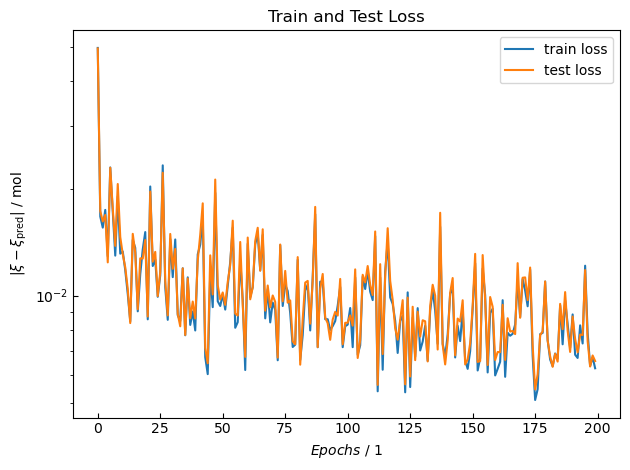

In [9]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

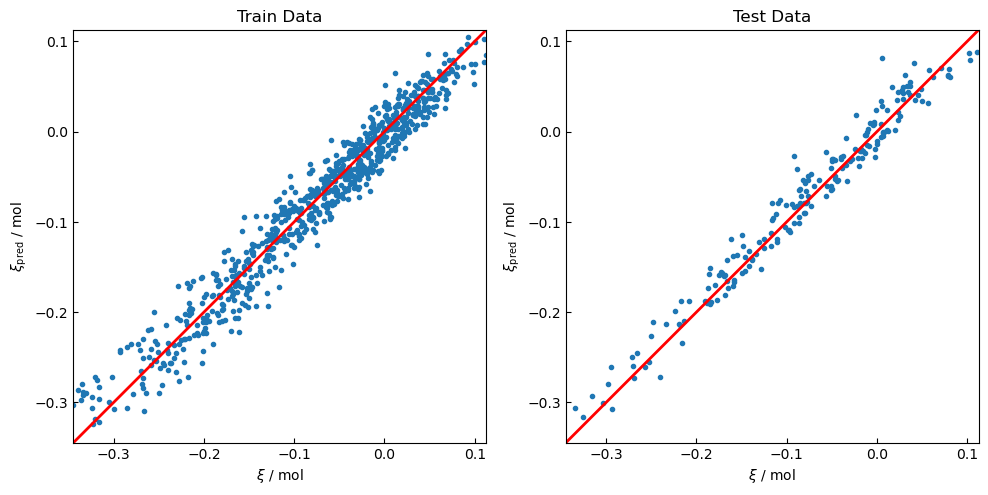

In [10]:
xi_real = []
xi_pred = []
for (X,y) in train_dataloader:
    xi_real = np.append(xi_real, y.numpy())
    xi_pred = np.append(xi_pred, net(X).detach().numpy())

xi_real_test = []
xi_pred_test = []
for (X,y) in test_dataloader:
    xi_real_test = np.append(xi_real_test, y.numpy())
    xi_pred_test = np.append(xi_pred_test, net(X).detach().numpy())

# find the boundaries of X and Y values
bounds = (min(xi_real.min(), xi_pred.min()) - int(0.1 * xi_pred.min()), max(xi_real.max(), xi_pred.max())+ int(0.1 * xi_pred.max()))

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(xi_real, xi_pred, '.')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(xi_real_test, xi_pred_test, '.')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

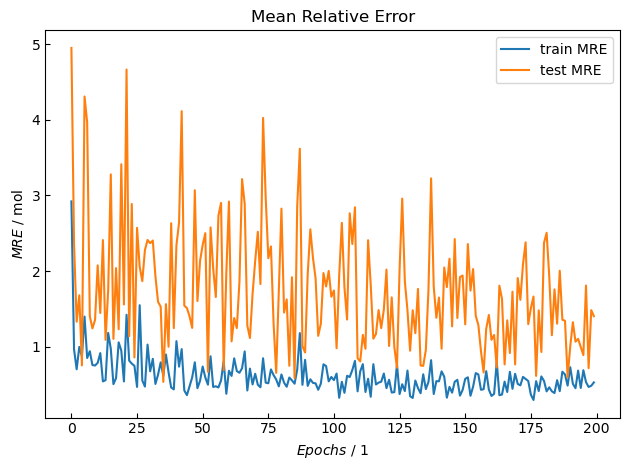

In [11]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_MRE, label='train MRE')
ax.plot(test_MRE, label='test MRE')
plt.title("Mean Relative Error")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

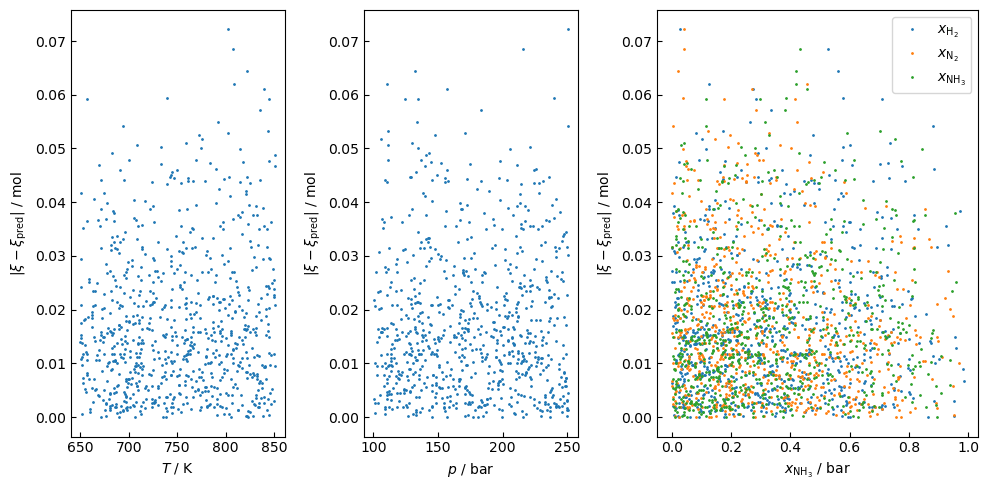

In [12]:
mistake = []
param_T = []
param_p = []
param_x_H2 = []
param_x_N2 = []
param_x_NH3 = []
for X,y in train_dataloader:
    mistake = np.append(mistake, abs(y - net(X).detach().numpy()))
    param_T = np.append(param_T, X[:,0])
    param_p = np.append(param_p, X[:,1])
    param_x_H2 = np.append(param_x_H2, X[:,2])
    param_x_N2 = np.append(param_x_N2, X[:,3])
    param_x_NH3 = np.append(param_x_NH3, X[:,4])
    
# train_parameters, train_xi = next(iter(train_dataloader))
# y = abs(train_xi - net(train_parameters).detach().numpy())
# #[T, p ,x_H2, x_N2, x_NH3]
# x = [train_parameters[:,0], train_parameters[:,1], train_parameters[:,2], train_parameters[:,3], train_parameters[:,4]]

# print(param_T[0])
# print(param_T)
# print(mistake)

fig,ax = plt.subplots(1,3, figsize = (10, 5), gridspec_kw={'width_ratios': [2,2,3]})

ax[0].plot(param_T, mistake, '.', markersize = 2)
ax[0].set(xlabel = '$T$ / K', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)

ax[1].plot(param_p, mistake, '.', markersize = 2)
ax[1].set(xlabel = '$p$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)

ax[2].plot(param_x_H2, mistake, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[2].plot(param_x_N2, mistake, '.', markersize = 2, label = '$x\mathregular{_{N_2}}$')
ax[2].plot(param_x_NH3, mistake, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[2].set(xlabel = '$x\mathregular{_{NH_3}}$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[2].tick_params(direction = 'in') #, length = 20, width = 3)
ax[2].set

plt.legend()
plt.tight_layout()
plt.show()

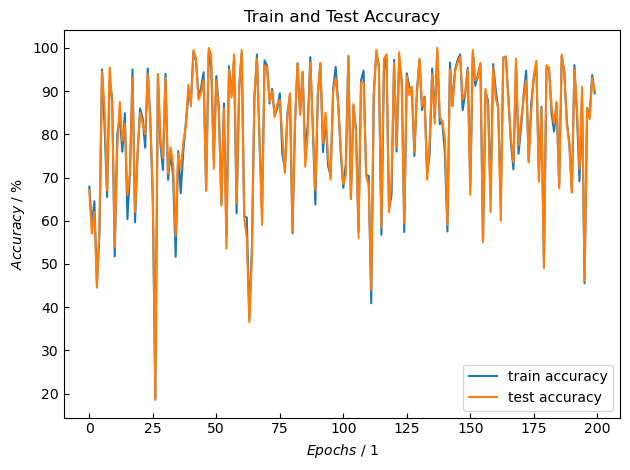

In [13]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [14]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y.reshape((-1,1)))
    print(net(X))
    break

tensor([[6.8953e+02, 2.1138e+02, 2.0038e-01, 4.8032e-01, 3.1930e-01],
        [7.7178e+02, 1.3325e+02, 7.4117e-01, 2.6780e-02, 2.3205e-01],
        [7.1468e+02, 1.7358e+02, 1.5285e-01, 3.4958e-02, 8.1220e-01],
        [8.2088e+02, 1.5333e+02, 6.2761e-01, 2.4678e-01, 1.2560e-01],
        [8.0539e+02, 1.1069e+02, 6.4937e-01, 1.7997e-01, 1.7066e-01],
        [7.6488e+02, 2.4551e+02, 2.5730e-01, 7.1775e-01, 2.4944e-02],
        [7.6973e+02, 1.3614e+02, 6.0239e-01, 4.9534e-02, 3.4807e-01],
        [8.1071e+02, 1.1573e+02, 1.5321e-01, 1.9933e-01, 6.4746e-01],
        [8.3241e+02, 1.9942e+02, 3.6760e-01, 3.4684e-01, 2.8556e-01],
        [6.9194e+02, 1.6590e+02, 6.2578e-01, 1.6624e-01, 2.0797e-01],
        [7.7592e+02, 1.0599e+02, 1.0134e-01, 1.4665e-01, 7.5201e-01],
        [7.2562e+02, 1.9470e+02, 2.6268e-01, 2.9386e-01, 4.4346e-01],
        [6.5516e+02, 1.3160e+02, 4.5971e-01, 8.8985e-02, 4.5130e-01],
        [6.8824e+02, 1.3350e+02, 2.3740e-01, 3.0713e-01, 4.5547e-01],
        [8.1941e+02,

#### Einblick in Netzwerk

In [15]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([0.9900, 0.9374, 0.9989, 0.9971, 0.9973], requires_grad=True),
 Parameter containing:
 tensor([-0.0082,  0.0119,  0.0009,  0.0169, -0.0026], requires_grad=True),
 Parameter containing:
 tensor([[ 0.4122,  0.0521,  0.1454, -0.0878,  0.2605],
         [-0.3360,  0.1166, -0.2642,  0.2935, -0.1781],
         [-0.1971,  0.0076,  0.4151,  0.0606,  0.4390],
         [-0.0086,  0.2319,  0.0054, -0.3092, -0.2545],
         [-0.0506, -0.0339,  0.1321, -0.2896, -0.4307],
         [ 0.2293,  0.1130,  0.2998, -0.2190, -0.0036],
         [-0.3740,  0.0760,  0.4065,  0.1032, -0.4270],
         [ 0.3823,  0.0211, -0.2293,  0.0166,  0.1854],
         [ 0.4074, -0.3962,  0.3242, -0.3257, -0.0943],
         [ 0.2679, -0.1376,  0.4158,  0.4066,  0.2409],
         [ 0.0132,  0.1662,  0.2103,  0.2454, -0.1119],
         [ 0.3535,  0.1156, -0.3320,  0.0833, -0.4209],
         [-0.3992, -0.1484, -0.2533,  0.0963, -0.2635],
         [-0.0950,  0.0716, -0.1766,  0.3632,  0.1020],


In [16]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.6107, 0.3982, 0.0504, 0.5334, 0.8284],
        [0.7478, 0.9529, 0.5726, 0.0721, 0.1004]])
tensor([[-0.1218],
        [-0.0101]], grad_fn=<AddmmBackward0>)


In [17]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [18]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    break

tensor([[6.8026e+02, 2.5057e+02, 2.0205e-01, 8.8072e-02, 7.0987e-01],
        [7.9993e+02, 1.6369e+02, 1.2379e-02, 8.2223e-01, 1.6539e-01],
        [8.2923e+02, 1.3244e+02, 2.5635e-01, 3.6703e-01, 3.7662e-01],
        [6.5100e+02, 2.1208e+02, 6.1239e-01, 1.6170e-01, 2.2591e-01],
        [7.9285e+02, 1.8020e+02, 4.9785e-01, 4.1357e-01, 8.8582e-02],
        [7.8863e+02, 1.9505e+02, 6.6970e-01, 1.3105e-01, 1.9925e-01],
        [7.3954e+02, 2.1381e+02, 3.8580e-01, 1.5996e-01, 4.5423e-01],
        [8.2498e+02, 1.2240e+02, 7.1009e-01, 1.7525e-01, 1.1466e-01],
        [6.5761e+02, 2.1144e+02, 4.6053e-02, 4.4350e-01, 5.1045e-01],
        [7.6668e+02, 2.0035e+02, 2.9993e-01, 9.7857e-02, 6.0221e-01],
        [7.9258e+02, 1.8763e+02, 5.7403e-01, 3.0813e-02, 3.9516e-01],
        [8.3241e+02, 1.9942e+02, 3.6760e-01, 3.4684e-01, 2.8556e-01],
        [6.8395e+02, 1.5589e+02, 9.7204e-01, 1.2524e-02, 1.5435e-02],
        [8.2261e+02, 2.1440e+02, 2.3414e-01, 1.1897e-01, 6.4689e-01],
        [7.1402e+02,